# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

# Imports

In [10]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [17]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# bivariate data viz - y_true vs y_pred
def plot_diff(y_true, y_pred, title=''):
  plt.scatter(y_true, y_pred)
  plt.plot([-100, 100], [-100, 100]) # plots a straight line with same x,y coords

  plt.title(title)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')

  plt.axis('equal') # changes limits of x or y axis so that equal increments of x and y have the same length
  plt.axis('square') # changes the limit ranges (xmax-xmin) and (ymax-ymin) of the x and y axes to be the same, and have the same scaling, resulting in a square plot
  
  
  plt.xlim(plt.xlim()) 
  plt.ylim(plt.ylim())

  plt.show()

def plot_metrics(metric_name, title, ylim=5):
  plt.plot(history.history[metric_name], color= 'blue', label = metric_name)
  plt.plot(history.history['val_' + metric_name], color= 'green', label = 'val_' + metric_name)

  plt.title(title)
  plt.ylim(0, ylim)
  plt.legend()

  plt.show()

  
  

# Prepare the Data
We download the dataset and format it for training.

In [8]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

# Model

Changes for multi-output models:
* in Model() class: `outputs=[y1_output, y2_output]`
* model.compile() : 
  * `loss = {'y1_output': 'mse', 'y2_output': 'mse'}`
  * ```
     metrics = {'y1_output': tf.keras.metrics.RootMeanSquaredError(), 
                'y2_output': tf.keras.metrics.RootMeanSquaredError()}
    ```



In [11]:
# layers

input_layer = keras.layers.Input( shape=(len(train.columns), ) )
first_dense = keras.layers.Dense(units = '128', activation = 'relu')(input_layer)
second_dense = keras.layers.Dense(units='128', activation = 'relu')(first_dense)

y1_output = Dense(units ='1', name = 'y1_output')(second_dense)
third_dense = Dense(units = '64', activation = 'relu')(second_dense)

y2_output = Dense(units = '1', name = 'y2_output')(third_dense)

model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

In [12]:
optimizer = keras.optimizers.SGD(lr=0.001)
model.compile(
              optimizer = optimizer,
              loss = {'y1_output': 'mse', 'y2_output': 'mse'},
              metrics = { 'y1_output': keras.metrics.RootMeanSquaredError(),
                          'y2_output': keras.metrics.RootMeanSquaredError()
                        }
)

In [13]:
type(train_Y)

tuple

In [14]:
history = model.fit(
    norm_train_X,
    train_Y,
    epochs = 500,
    batch_size = 10,
    validation_data = (norm_test_X, test_Y)
)

Epoch 1/500
62/62 [==============================] - 1s 7ms/step - loss: 537.0645 - y1_output_loss: 256.8423 - y2_output_loss: 280.2222 - y1_output_root_mean_squared_error: 15.3627 - y2_output_root_mean_squared_error: 16.0663 - val_loss: 46.8057 - val_y1_output_loss: 18.2465 - val_y2_output_loss: 28.5592 - val_y1_output_root_mean_squared_error: 4.2716 - val_y2_output_root_mean_squared_error: 5.3441
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 38.9446 - y1_output_loss: 14.2143 - y2_output_loss: 24.7303 - y1_output_root_mean_squared_error: 3.7420 - y2_output_root_mean_squared_error: 4.9077 - val_loss: 26.2234 - val_y1_output_loss: 11.5750 - val_y2_output_loss: 14.6484 - val_y1_output_root_mean_squared_error: 3.4022 - val_y2_output_root_mean_squared_error: 3.8273
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 26.5324 - y1_output_loss: 10.7094 - y2_output_loss: 15.8230 - y1_output_root_mean_squared_error: 3.2608 - y2_output_root_mean_sq

# Evaluate Model and Plot Metrics

In [15]:
# Evaluate
# - print loss and rmse for both outputs
# loss is y1_output_loss + y2_output_loss

loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x = norm_test_X, y = test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 0.9281 - y1_output_loss: 0.2502 - y2_output_loss: 0.6779 - y1_output_root_mean_squared_error: 0.5002 - y2_output_root_mean_squared_error: 0.8234
Loss = 0.9281019568443298, Y1_loss = 0.25018593668937683, Y1_mse = 0.5001859068870544, Y2_loss = 0.6779160499572754, Y2_mse = 0.823356568813324


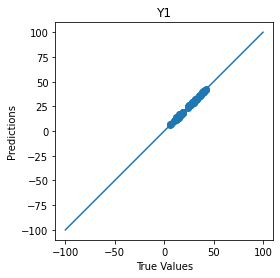

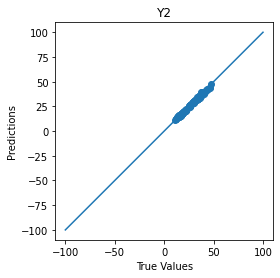

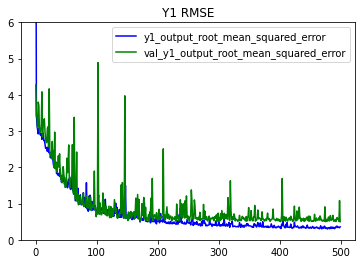

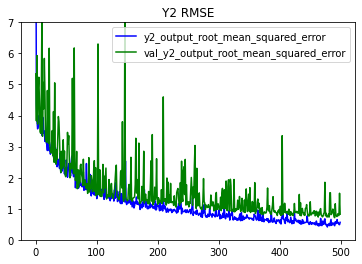

In [18]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)